In [1]:
%matplotlib inline




# Example 10: Extracellular stimulation of neurons
This is an example of **``LFPy``** running in an **``Jupyter notebook``**. To run through this example code and produce output, press **``<shift-Enter>``** in each code block below.

First step is to **import ``LFPy``** and other packages for analysis and plotting:

In [ ]:
import LFPy
import MEAutility as mu
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

Create some dictionarys with parameters for cell:

In [3]:
cellParameters = {
    'morphology' : 'morphologies/L5_Mainen96_LFPy.hoc',
    'tstart' : -50, # ignore startup transients
    'tstop' : 100,
    'dt' : 2**-4,
    'v_init' : -60, 
    'passive' : False,
}

Create an helper function to instantiate a **cell** object given a set of parameters:

In [4]:
def instantiate_cell(cellParameters):
    cell = LFPy.Cell(**cellParameters, delete_sections=True)
    cell.set_pos(x=0, y=0, z=0)
    cell.set_rotation(x=4.98919, y=-4.33261, z=np.pi) # Align apical dendrite with z-axis

    # insert hh mechanism in everywhere, reduced density elsewhere
    for sec in cell.allseclist:
        sec.insert('hh')
        if not 'soma' in sec.name():
            # reduce density of Na- and K-channels to 5% in dendrites
            sec.gnabar_hh = 0.006
            sec.gkbar_hh = 0.0018
            
    return cell

In [5]:
def plot_results(cell, electrode):
    fig = plt.figure(figsize=(10, 6))
    gs = GridSpec(2, 2)

    ax = fig.add_subplot(gs[0, 1])
    im = ax.pcolormesh(np.array(cell.t_ext), cell.z.mean(axis=-1), np.array(cell.v_ext),
                       cmap='RdBu', vmin=-100, vmax=100,
                       shading='auto')
    ax.set_title('Applied extracellular potential')
    ax.set_ylabel('z (um)', labelpad=0)
    rect = np.array(ax.get_position().bounds)
    rect[0] += rect[2] + 0.01
    rect[2] = 0.01
    cax = fig.add_axes(rect)
    
    cbar = fig.colorbar(im, cax=cax, extend='both')
    cbar.set_label('(mV)', labelpad=0)

    ax = fig.add_subplot(gs[1, 1], sharex=ax)
    ax.plot(cell.tvec, cell.somav, 'k')
    ax.set_title('somatic voltage')
    ax.set_ylabel('(mV)', labelpad=0)
    ax.set_xlabel('t (ms)')
    ax.set_ylim([-90, 20])
    ax.set_xlim(cell.tvec[0], cell.tvec[-1])

    ax = fig.add_subplot(gs[:, 0])
    for sec in cell.allseclist:
        idx = cell.get_idx(sec.name())
        ax.plot(cell.x[idx], cell.z[idx],
                color='k')
        if 'soma' in sec.name():
            ax.plot(cell.x[idx], cell.z[idx], color='b', lw=5)
    ax.plot(electrode.x, electrode.z, marker='o', color='g', markersize=3)
    ax.plot(electrode.x[stim_elec], electrode.z[stim_elec], marker='o', color='r', markersize=5)
    ax.axis([-500, 500, -400, 1200])

Instantiate a **`LFPy.Cell`** object:

In [6]:
cell = instantiate_cell(cellParameters)

Create an **electrode** using a commercially available design from Neuronexus:

In [7]:
probe = mu.return_mea('Neuronexus-32')

Rotate the probe and move it so that it is in the xz plane and 50 $\mu$m away from the soma:

In [8]:
probe.rotate(axis=[0, 0, 1], theta=90)
probe.move([0, 100, 0])

Create a pulse stimulation current:

In [9]:
amp = 20000
n_pulses = 2
interpulse = 10
width = 2
dt = cell.dt
t_stop = cell.tstop
t_start = 20
stim_elec = 15

current, t_ext = probe.set_current_pulses(el_id=stim_elec, amp1=amp, width1=width, dt=dt, t_stop=t_stop,
                                          t_start=t_start, n_pulses=n_pulses, interpulse=interpulse)

(0.0, 100.0)

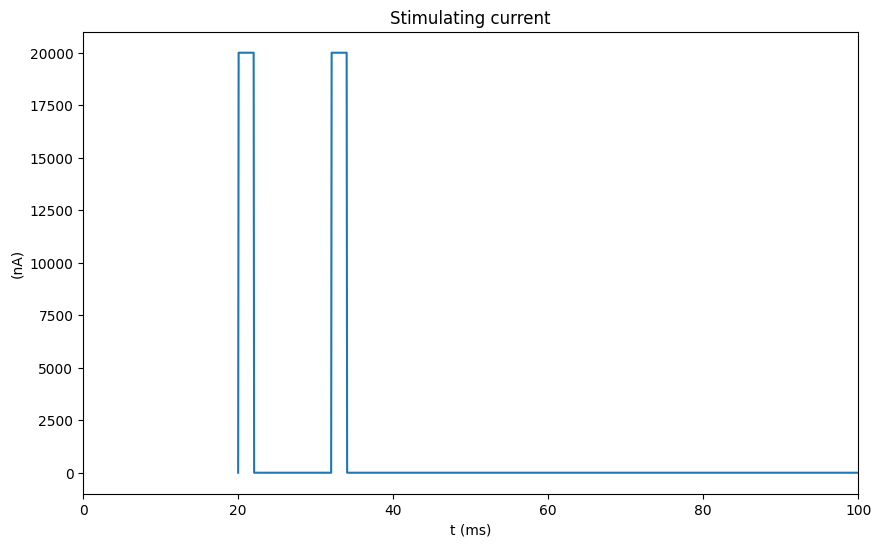

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(t_ext, current)
plt.title("Stimulating current")
plt.xlabel('t (ms)')
plt.ylabel('(nA)')
plt.xlim(0, cell.tstop)

Create ``LFPy`` **electrode** object:

In [11]:
electrode = LFPy.RecExtElectrode(cell=cell, probe=probe)

Enable extracellular stimulation for the **cell** using stimulating currents of the **electrode** object:

In [12]:
v_ext = cell.enable_extracellular_stimulation(electrode, t_ext=t_ext) 

Run the simulation with **`electrode`** as input to **`cell.simulate()`**

In [13]:
cell.simulate(probes=[electrode], rec_vmem=True)

Then plot the **somatic potential**, the **extracellular field** and the **LFP**
from electrode object:

/var/folders/vj/4k3qdfmx21vc8l54r_ck8vr40000gn/T/ipykernel_23957/2952205653.py:6: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im = ax.pcolormesh(np.array(cell.t_ext), cell.z.mean(axis=-1), np.array(cell.v_ext),


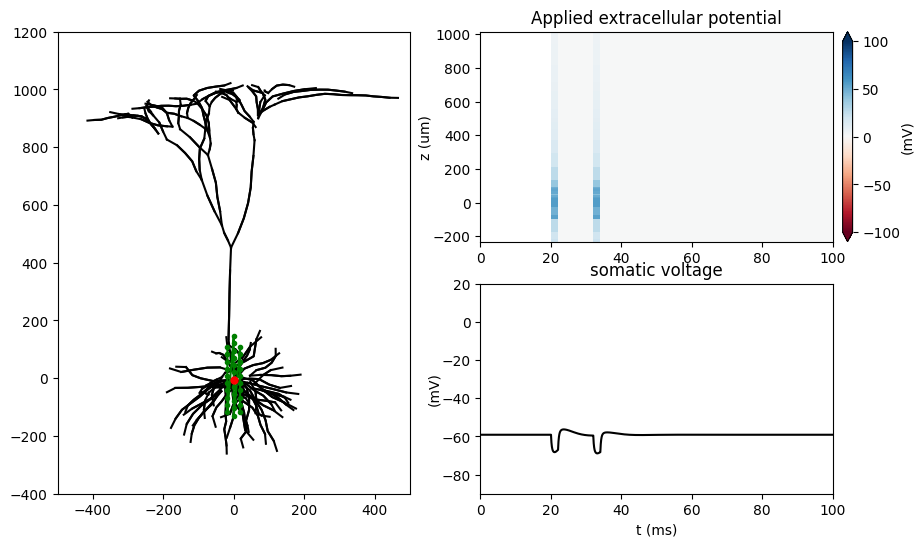

In [14]:
plot_results(cell, electrode)

Positive pulses close to the soma location cause an hyperpolarization in the cell. Let's try something else!

In [15]:
cell = instantiate_cell(cellParameters)

Use the ``probe`` field in the **electrode** object created before to overwrite currents:

In [16]:
amp = -20000
n_pulses = 2
interpulse = 10
width = 2
dt = cell.dt
t_stop = cell.tstop
t_start = 20
stim_elec = 15

electrode = LFPy.RecExtElectrode(cell=cell, probe=probe)
current, t_ext = electrode.probe.set_current_pulses(el_id=stim_elec, amp1=amp, width1=width, dt=dt, 
                                                    t_stop=t_stop, t_start=t_start, n_pulses=n_pulses,
                                                    interpulse=interpulse)

In [17]:
v_ext = cell.enable_extracellular_stimulation(electrode, t_ext=t_ext) 
cell.simulate(probes=[electrode], rec_vmem=True)

/var/folders/vj/4k3qdfmx21vc8l54r_ck8vr40000gn/T/ipykernel_23957/2952205653.py:6: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im = ax.pcolormesh(np.array(cell.t_ext), cell.z.mean(axis=-1), np.array(cell.v_ext),


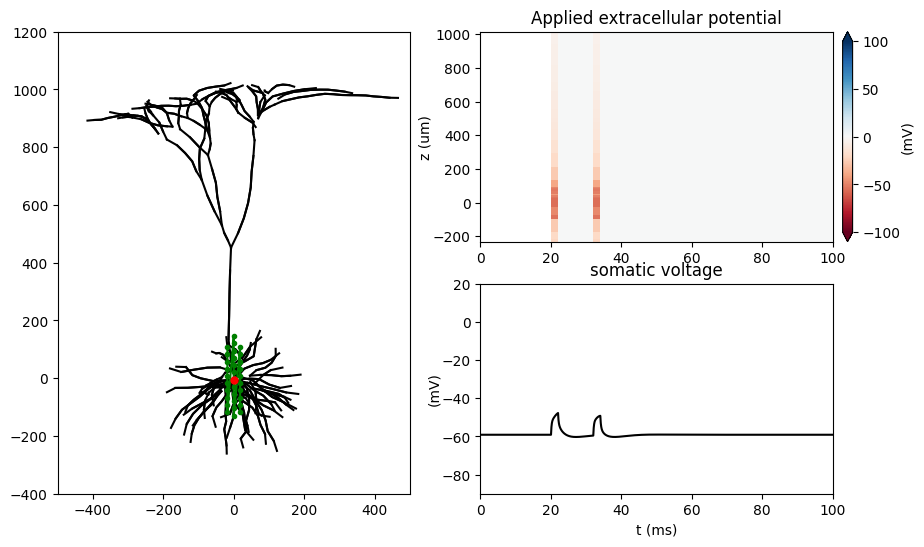

In [18]:
plot_results(cell, electrode)

Now the membrane potential is depolarizing, but stimulation is not strong enough to elicit an action potential.
Try to crank up the stimulation current to 50$\mu A$

In [19]:
amp = -75000

electrode = LFPy.RecExtElectrode(cell=cell, probe=probe)
current, t_ext = electrode.probe.set_current_pulses(el_id=stim_elec, amp1=amp, width1=width, dt=dt, 
                                                    t_stop=t_stop, t_start=t_start, n_pulses=n_pulses,
                                                    interpulse=interpulse)
cell = instantiate_cell(cellParameters)
v_ext = cell.enable_extracellular_stimulation(electrode, t_ext=t_ext) 
cell.simulate(probes=[electrode], rec_vmem=True)

/var/folders/vj/4k3qdfmx21vc8l54r_ck8vr40000gn/T/ipykernel_23957/2952205653.py:6: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im = ax.pcolormesh(np.array(cell.t_ext), cell.z.mean(axis=-1), np.array(cell.v_ext),


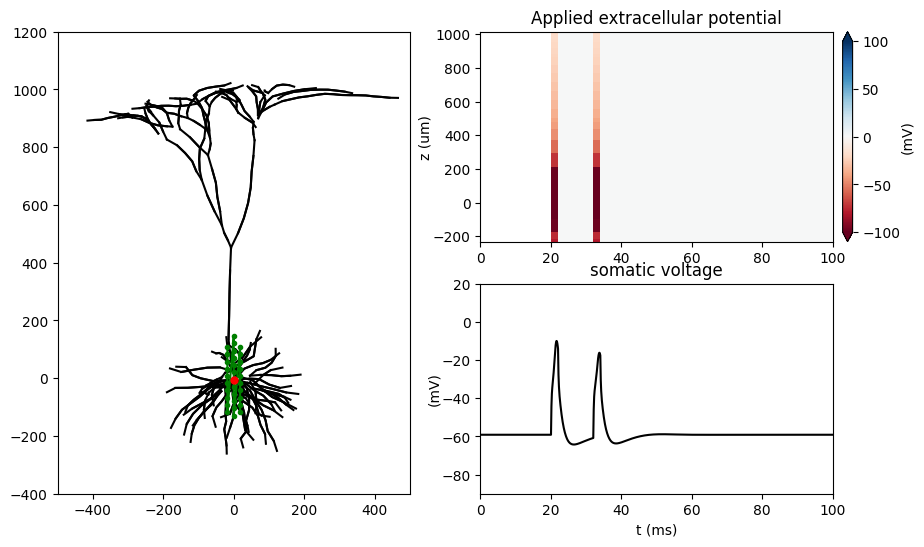

In [20]:
plot_results(cell, electrode)

Finally we got two spikes. We can maybe get the same effect with smaller currents and higher stimulation frequencies / number of pulses / pulse width. Try to increase the pulse width:

In [21]:
amp = -30000
n_pulses = 1
interpulse = 10
width = 15
dt = cell.dt
t_stop = cell.tstop
t_start = 20
stim_elec = 15

electrode = LFPy.RecExtElectrode(cell=cell, probe=probe)
current, t_ext = electrode.probe.set_current_pulses(el_id=stim_elec, amp1=amp, width1=width, dt=dt, 
                                                    t_stop=t_stop, t_start=t_start, n_pulses=n_pulses,
                                                    interpulse=interpulse)
cell = instantiate_cell(cellParameters)
v_ext = cell.enable_extracellular_stimulation(electrode, t_ext=t_ext) 
cell.simulate(probes=[electrode], rec_vmem=True)

/var/folders/vj/4k3qdfmx21vc8l54r_ck8vr40000gn/T/ipykernel_23957/2952205653.py:6: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im = ax.pcolormesh(np.array(cell.t_ext), cell.z.mean(axis=-1), np.array(cell.v_ext),


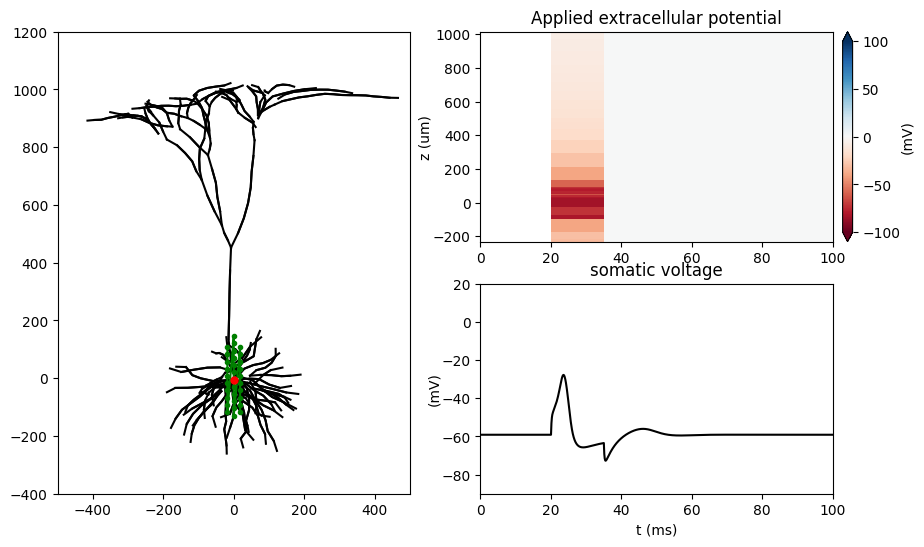

In [22]:
plot_results(cell, electrode)